### Wakefield simulation of accelerator cavity with `wakis`

* EM Simulation of a lossy cylindrical accelerator cavity up to a partially decayed wake
* Calculation of the longitudinal wake potential and impedance of partially decayed and:
    * Partially decayed to fully decayed impedance with [IDDEFIX](https://github.com/ImpedanCEI/IDDEFIX) Differential Evolution algorithm
    * Extrapolation of partially decayed wake to fully decayed with [IDDEFIX](https://github.com/ImpedanCEI/IDDEFIX) Resonator formalism
* Plotting of the results

In [2]:
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt

from wakis import SolverFIT3D
from wakis import GridFIT3D 
from wakis import WakeSolver

%matplotlib ipympl

### Domain setup and grid generation

Wakis will import the geometry files stored in `.stl` format and generate a grid with the number of mesh cells selected by the user `Nx`, `Ny`, `Nz`. The same geometry as example `002_Wakefield_simulation.ipynb` will be used, and futher details on the simulation and visualization can be found there.

In [ ]:
# ---------- Domain setup ---------
# Read geometry -change path if errors are found!
stl_cavity = 'data/002_vacuum_cavity.stl' 
stl_shell = 'data/002_lossymetal_shell.stl'

# Set up geometry & materials dictionaries
stl_solids = {'cavity': stl_cavity, 'shell': stl_shell}
stl_materials = {'cavity': 'vacuum', 'shell': [30, 1.0, 30]}

# Domain bounds
surf = pv.read(stl_shell) + pv.read(stl_cavity)
xmin, xmax, ymin, ymax, zmin, zmax = surf.bounds
Lx, Ly, Lz = (xmax-xmin), (ymax-ymin), (zmax-zmin)

# Number of mesh cells
Nx = 80
Ny = 80
Nz = 141
#dt = 2.187760221e-12 # like CST

# set grid and geometry
grid = GridFIT3D(xmin, xmax, ymin, ymax, zmin, zmax, Nx, Ny, Nz, 
                stl_solids=stl_solids, 
                stl_materials=stl_materials,
                stl_scale=1.0)

### Boundary conditions and EM solver

In [ ]:
# boundary conditions
bc_low=['pec', 'pec', 'pec']
bc_high=['pec', 'pec', 'pec']

solver = SolverFIT3D(grid, 
                     bc_low=bc_low, bc_high=bc_high, 
                     use_stl=True, bg='pec')

### Wakefield settings & Run

The wakefield simulation will run up to 10 m which will give a partially decayed wake and a non-converged impedance - this will be the starting point of IDDEFIX extrapolation !

In [3]:
# ------------ Beam source ----------------
# Beam parameters
sigmaz = 10e-2      #[m] -> 2 GHz
q = 1e-9            #[C]
beta = 1.0          # beam beta 
xs = 0.             # x source position [m]
ys = 0.             # y source position [m]
xt = 0.             # x test position [m]
yt = 0.             # y test position [m]
# [DEFAULT] tinj = 8.53*sigmaz/c_light  # injection time offset [s] 


# ----------- Solver  setup  ----------
# Wakefield post-processor
wakelength = 10. # [m] -> Partially decayed
add_space = 10   # no. cells

wake = WakeSolver(q=q, sigmaz=sigmaz, beta=beta,
                xsource=xs, ysource=ys, xtest=xt, ytest=yt,
                add_space=add_space,
                results_folder='results/',
                Ez_file='results/001_Ez.h5',)

The cell bellow will run the wakefield simulation with the defined beam source and wakelength 

In [ ]:
solver.wakesolve(wakelength=wakelength, 
                 wake=wake, 
                 add_space=add_space,
                 plot=False)

Or, if results have already been generated:

In [4]:
wake.load_results("results")

It's done! Now we can plot the results:

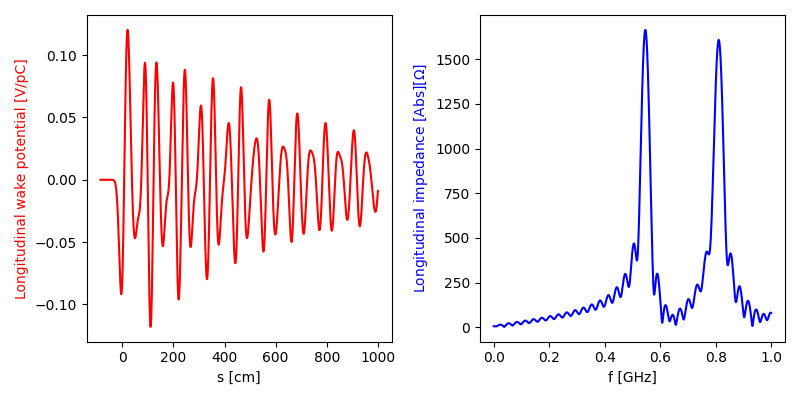

In [5]:
fig, ax = plt.subplots(1,2, figsize=[8,4], dpi=100)
ax[0].plot(wake.s*1e2, wake.WP, c='r', lw=1.5, label='Wakis')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Longitudinal wake potential [V/pC]', color='r')

ax[1].plot(wake.f*1e-9, np.abs(wake.Z), c='b', lw=1.5, label='Wakis')
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel('Longitudinal impedance [Abs][$\Omega$]', color='b')

fig.tight_layout()

## Partial to Fully decayed impedance with IDDEFIX

The [IDDEFIX](https://github.com/ImpedanCEI/IDDEFIX) (Impedance Determination through Differential Evolution FItting and eXtrapolation) python package will take the partially decayed wake and give back the fully decayed wake using the **Resonator formalism** and **Diferential Evolution's** algorithms powered with `scipy`

In [7]:
import iddefix

### IDDEFIX setup & Run

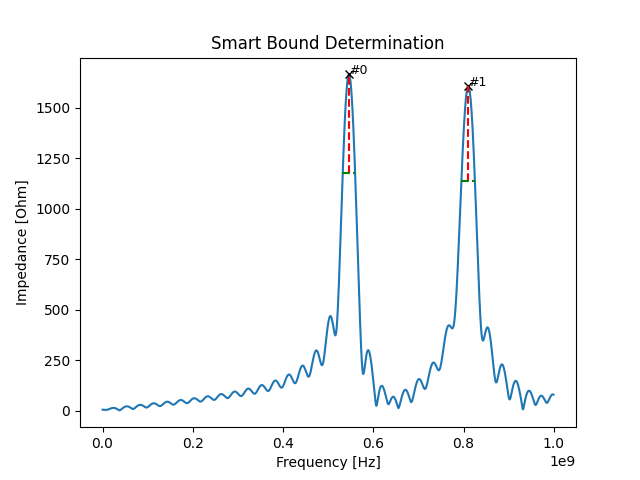

In [8]:
# Setting amount of resonators to fit

Nres = 2

# Bounds on resonators parameters
""" In this example, we will use the SmartBoundDetermination class to determine the bounds on the resonators parameters. 
By using SmartBoundDetermination ther is no need to specify the bounds manually."""

SBD = SBD_parameterBound = iddefix.SmartBoundDetermination(wake.f, np.abs(wake.Z), minimum_peak_height=1000)
SBD.inspect() # Inspects the data and shows the peaks
parameterBounds = SBD_parameterBound.find() # Returns the bounds on the resonators parameters


In [28]:
%%time
DE_model = iddefix.EvolutionaryAlgorithm(wake.f, 
                                         wake.Z,
                                         N_resonators=Nres, 
                                         parameterBounds=parameterBounds,
                                         plane="longitudinal", 
                                         wake_length=10)

DE_model.run_differential_evolution(maxiter=30000,
                                    popsize=30,
                                    tol=0.0001,
                                    mutation=(0.4, 1.0),
                                    crossover_rate=0.7)
print(DE_model.warning)


Optimization Progress:   1%|          | 152/30000 [00:01<05:12, 95.56it/s] 



----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        2.63e+03        |      59.50       |    5.467e+08     
    2     |        1.99e+03        |      50.85       |    8.097e+08     
----------------------------------------------------------------------
Optimization terminated successfully.
CPU times: user 1.21 s, sys: 188 ms, total: 1.4 s
Wall time: 1.59 s


### Running minimization algorithm

In [29]:
DE_model.run_minimization_algorithm()

Method for minimization : Nelder-Mead


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        2.63e+03        |      59.41       |    5.467e+08     
    2     |        1.99e+03        |      50.88       |    8.097e+08     
----------------------------------------------------------------------


### Plot the partially decayed resonator result

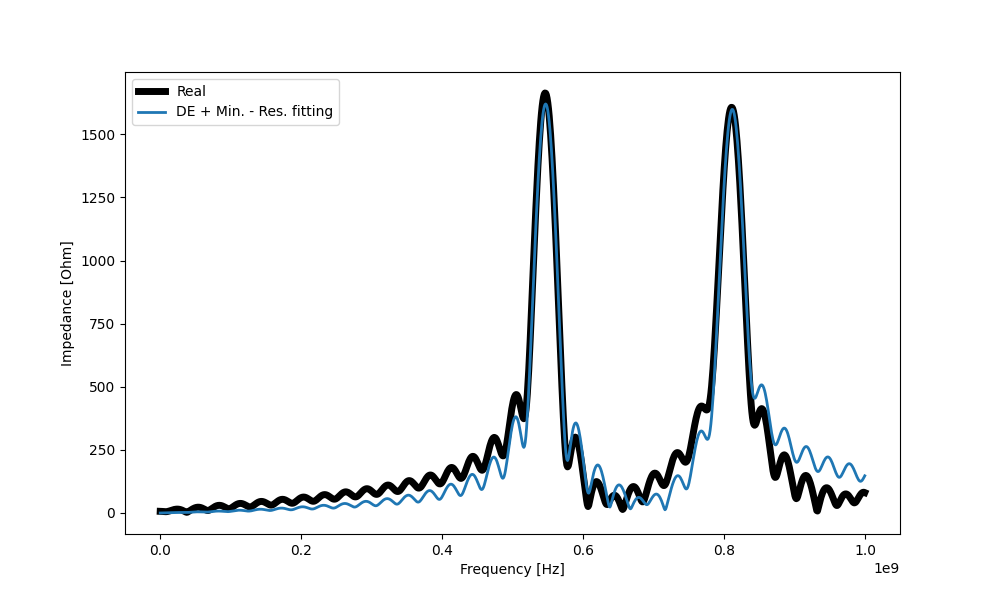

In [30]:
plt.figure(figsize=(10, 6))
result_DE_MIN = np.abs(DE_model.fitFunction(wake.f, iddefix.objectiveFunctions.pars_to_dict(DE_model.evolutionParameters)))

plt.plot(wake.f, np.abs(wake.Z), lw=5, label='Real', color='black')
plt.plot(wake.f, result_DE_MIN,  lw=2, label='DE + Min. - Res. fitting')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Impedance [Ohm]')
plt.legend()

### Plot the extrapolation result

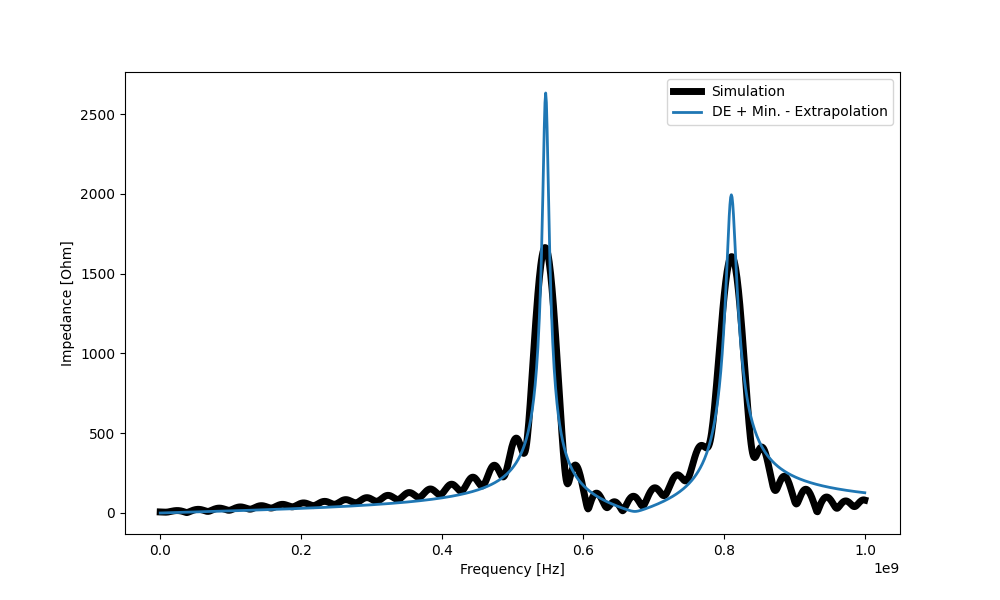

In [31]:
plt.figure(figsize=(10, 6))
result_DE_MIN = np.abs(iddefix.Impedances.n_Resonator_longitudinal_imp(wake.f, DE_model.evolutionParameters))

plt.plot(wake.f, np.abs(wake.Z), lw=5, label='Simulation', color='black')
plt.plot(wake.f, result_DE_MIN,  lw=2, label='DE + Min. - Extrapolation')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Impedance [Ohm]')
plt.legend()